In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [4]:
df = pd.read_csv('./income.csv')
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [5]:
df.isnull().sum()

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income >50K          0
dtype: int64

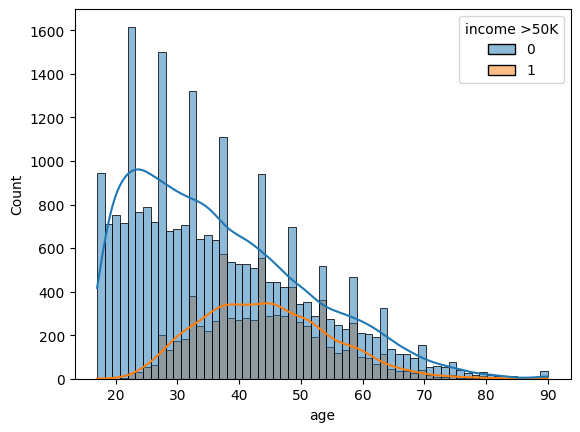

In [6]:
sns.histplot(data=df, x=df['age'], hue=df['income >50K'], kde=True)
plt.show()

In [7]:
df['income >50K'].value_counts() / len(df) * 100

income >50K
0    75.919044
1    24.080956
Name: count, dtype: float64

In [8]:
df.shape

(32561, 14)

In [9]:
df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)
df['occupation'].fillna(df['occupation'].mode()[0], inplace=True)
df['native-country'].fillna(df['native-country'].mode()[0], inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_15132\1006053529.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_15132\1006053529.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [10]:
df.isnull().sum()

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income >50K       0
dtype: int64

In [11]:
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [12]:
df.select_dtypes('object').columns.to_list()

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [13]:
df.shape

(32561, 14)

In [19]:
df = pd.get_dummies(df, columns=['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country'], drop_first=True, dtype=int)
df.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,income >50K,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,13,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,53,7,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
x = df.drop('income >50K', axis=1)
y = df['income >50K']

In [ ]:
# from sklearn.feature_selection import SelectKBest, f_classif

# best = SelectKBest(score_func=f_classif, k=10)

# best.fit_transform(x, y)

# score = pd.DataFrame(best.scores_, columns=['Score'])

# name_col = pd.DataFrame(x.columns)

# top_feature = pd.concat([name_col, score], axis=1)

# top_feature.nlargest(10, 'Score')

,0,Score
28,marital-status_Married-civ-spouse,8025.842062
1,education-num,4120.095780
30,marital-status_Never-married,3674.200147
0,age,1886.707314
4,hours-per-week,1813.386282
48,relationship_Own-child,1794.157489
2,capital-gain,1709.150064
55,sex_Male,1593.107907
35,occupation_Exec-managerial,1575.848402
46,relationship_Not-in-family,1199.481344


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=42)

In [24]:
x_train.shape

(24420, 96)

In [27]:
y_train.shape

(24420,)

In [ ]:
smt = SMOTE()

x_train_smt, y_train_smt = smt.fit_resample(x_train, y_train)

In [26]:
x_train_smt.shape

(37012, 96)

In [31]:
y_train_smt.value_counts()

income >50K
0    18506
1    18506
Name: count, dtype: int64

In [ ]:
sc = StandardScaler()
x_train_final = sc.fit_transform(x_train_smt)
x_test_final = sc.transform(x_test)

In [51]:
dtm = DecisionTreeClassifier(max_depth=12, criterion='entropy', random_state=42)
dtm.fit(x_train_final, y_train_smt)

y_pred_dtm = dtm.predict(x_test_final)
print('\n\n', classification_report(y_test, y_pred_dtm))
confusion_matrix(y_test, y_pred_dtm)



               precision    recall  f1-score   support

           0       0.93      0.85      0.89      6214
           1       0.62      0.78      0.69      1927

    accuracy                           0.83      8141
   macro avg       0.77      0.81      0.79      8141
weighted avg       0.85      0.83      0.84      8141



array([[5275,  939],
       [ 424, 1503]])

In [65]:
rfm = RandomForestClassifier(n_estimators=115, criterion='entropy', max_depth=30, random_state=42, bootstrap=True, class_weight='balanced')
rfm.fit(x_train_final, y_train_smt)

y_pred_rfm = rfm.predict(x_test_final)
print('\n\n', classification_report(y_test, y_pred_rfm))
confusion_matrix(y_test, y_pred_rfm)



               precision    recall  f1-score   support

           0       0.92      0.88      0.90      6214
           1       0.65      0.74      0.70      1927

    accuracy                           0.85      8141
   macro avg       0.79      0.81      0.80      8141
weighted avg       0.85      0.85      0.85      8141



array([[5459,  755],
       [ 494, 1433]])

In [70]:
xgb = XGBClassifier()
xgb.fit(x_train_final, y_train_smt)

y_pred_xgb = xgb.predict(x_test_final)
print('\n\n', classification_report(y_test, y_pred_xgb))
confusion_matrix(y_test, y_pred_xgb)



               precision    recall  f1-score   support

           0       0.92      0.89      0.91      6214
           1       0.69      0.76      0.72      1927

    accuracy                           0.86      8141
   macro avg       0.81      0.83      0.81      8141
weighted avg       0.87      0.86      0.86      8141



array([[5555,  659],
       [ 470, 1457]])

In [78]:
roc_auc_score(y_test, y_pred_xgb)


0.8250233540314161

In [73]:
roc_auc_score(y_test, y_pred_rfm)

0.8110715646357581

In [74]:
roc_auc_score(y_test, y_pred_dtm)

0.814429233819076

In [7]:
import pandas as pd
t =[1, 2, 3, 4]

test = pd.DataFrame(t)